In [200]:
# ! pip3 install matplotlib

In [201]:
# all imports
import pandas as pd
import numpy as np
from numpy import absolute
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt

# Data Loading with some preprocess

In [202]:
train = pd.read_csv("data/origin/train.csv", index_col="row_id").dropna()
train["datetime"] = pd.to_datetime(train["datetime"])
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id
row_id,,,,,,,,
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2
...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,59


In [203]:
gas_prices = pd.read_csv("data/origin/gas_prices.csv").dropna()
gas_prices["forecast_date"] = pd.to_datetime(gas_prices["forecast_date"])
gas_prices.set_index("forecast_date", inplace=True)
# gas_prices["2022": "2022"]
gas_prices

,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
forecast_date,,,,
2021-09-01,45.23,46.32,2021-08-31,1
2021-09-02,45.62,46.29,2021-09-01,2
2021-09-03,45.85,46.40,2021-09-02,3
2021-09-04,46.30,46.80,2021-09-03,4
2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...
2023-05-26,29.10,34.10,2023-05-25,633
2023-05-27,28.30,34.10,2023-05-26,634
2023-05-28,28.10,34.10,2023-05-27,635


In [204]:
client = pd.read_csv("data/origin/client.csv").dropna()
client["date"] = pd.to_datetime(client["date"])
client["data_block_id"] -= 2
client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,0
1,2,0,17,166.40,0,2021-09-01,0
2,3,0,688,7207.88,0,2021-09-01,0
3,0,0,5,400.00,1,2021-09-01,0
4,1,0,43,1411.00,1,2021-09-01,0
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,635
41915,3,15,161,2035.75,0,2023-05-29,635
41916,0,15,15,620.00,1,2023-05-29,635
41917,1,15,20,624.50,1,2023-05-29,635


In [205]:
electricity_prices = pd.read_csv("data/origin/electricity_prices.csv").dropna()
electricity_prices["forecast_date"] = pd.to_datetime(electricity_prices["forecast_date"])
electricity_prices["origin_date"] = pd.to_datetime(electricity_prices["origin_date"])
electricity_prices.set_index("forecast_date", inplace=True)
electricity_prices

,euros_per_mwh,origin_date,data_block_id
forecast_date,,,
2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...
2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637


In [206]:
forecast_weather = pd.read_csv("data/origin/forecast_weather.csv").dropna()
forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


In [207]:
historical_weather = pd.read_csv("data/origin/historical_weather.csv").dropna()
historical_weather["data_block_id"] = historical_weather["data_block_id"].astype("int32")
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,4.6,0.0,0.0,1018.9,40,9,54,0,1.055556,253,567.0,392.0,175.0,59.7,26.2,637
1710798,2023-05-30 10:00:00,12.3,3.5,0.0,0.0,1019.0,46,4,70,0,0.805556,263,581.0,407.0,174.0,59.7,26.7,637
1710799,2023-05-30 10:00:00,9.8,3.0,0.0,0.0,1019.2,41,4,62,0,1.972222,285,609.0,432.0,177.0,59.7,27.2,637
1710800,2023-05-30 10:00:00,11.7,1.6,0.0,0.0,1019.0,44,0,73,0,3.500000,307,658.0,521.0,137.0,59.7,27.7,637


# EDA

## Many targets are 0s, why ?

In [208]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id
row_id,,,,,,,,
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2
...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,59


In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017824 entries, 0 to 2018351
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 138.6 MB


### electricity_prices (possible sol.: each hour = feature)

In [210]:
electricity_prices[electricity_prices["data_block_id"] == 1].describe()

,euros_per_mwh,origin_date,data_block_id
count,24.000000,24,24.0
mean,110.467083,2021-08-31 11:30:00,1.0
min,86.880000,2021-08-31 00:00:00,1.0
25%,94.135000,2021-08-31 05:45:00,1.0
50%,106.815000,2021-08-31 11:30:00,1.0
75%,126.820000,2021-08-31 17:15:00,1.0
max,145.910000,2021-08-31 23:00:00,1.0
std,19.703461,NaN,0.0


In [211]:
electricity_prices[electricity_prices["data_block_id"] == 10].describe()

,euros_per_mwh,origin_date,data_block_id
count,24.000000,24,24.0
mean,126.824167,2021-09-09 11:30:00,10.0
min,96.450000,2021-09-09 00:00:00,10.0
25%,103.195000,2021-09-09 05:45:00,10.0
50%,129.165000,2021-09-09 11:30:00,10.0
75%,148.785000,2021-09-09 17:15:00,10.0
max,162.270000,2021-09-09 23:00:00,10.0
std,25.502183,NaN,0.0


In [212]:
electricity_prices[electricity_prices["data_block_id"] == 20].describe()

,euros_per_mwh,origin_date,data_block_id
count,24.000000,24,24.0
mean,144.803750,2021-09-19 11:30:00,20.0
min,79.170000,2021-09-19 00:00:00,20.0
25%,98.910000,2021-09-19 05:45:00,20.0
50%,158.165000,2021-09-19 11:30:00,20.0
75%,174.382500,2021-09-19 17:15:00,20.0
max,205.000000,2021-09-19 23:00:00,20.0
std,40.002337,NaN,0.0


In [213]:
electricity_prices[electricity_prices["data_block_id"] == 30].describe()

,euros_per_mwh,origin_date,data_block_id
count,24.00000,24,24.0
mean,110.31750,2021-09-29 11:30:00,30.0
min,59.09000,2021-09-29 00:00:00,30.0
25%,85.22750,2021-09-29 05:45:00,30.0
50%,107.52500,2021-09-29 11:30:00,30.0
75%,142.04000,2021-09-29 17:15:00,30.0
max,185.00000,2021-09-29 23:00:00,30.0
std,33.91517,NaN,0.0


In [214]:
electricity_prices

,euros_per_mwh,origin_date,data_block_id
forecast_date,,,
2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...
2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637


In [215]:
electricity_prices = electricity_prices[["euros_per_mwh", "data_block_id"]].groupby(['data_block_id']).mean().reset_index()
data = []
data.insert(0, {'data_block_id': 0, 'euros_per_mwh': 110.1,})
electricity_prices = pd.concat([pd.DataFrame(data), electricity_prices], ignore_index=True)
electricity_prices

,data_block_id,euros_per_mwh
0,0,110.100000
1,1,110.467083
2,2,112.631250
3,3,107.429583
4,4,106.112917
...,...,...
633,633,54.062083
634,634,62.561667
635,635,44.451250
636,636,35.757083


# Preprocessing data

In [216]:
train["datetime_year"] = train["datetime"].dt.year
train["datetime_month"] = train["datetime"].dt.month
train["datetime_week"] = train["datetime"].dt.strftime("%w")
train = train.astype({"datetime_week": int,})
train["datetime_day"] = train["datetime"].dt.day
train["datetime_hour"] = train["datetime"].dt.hour
# train["datetime_minute"] = train["datetime"].dt.minute   # Exclude as each datetime in hourly NOT minutely
train["datetime_dayofweek"] = train["datetime"].dt.dayofweek

### Train

In [217]:
#train = train.drop("datetime", axis=1)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,datetime_week,datetime_day,datetime_hour,datetime_dayofweek
row_id,,,,,,,,,,,,,,
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2,2021,9,3,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,64,2023,5,3,31,23,2
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2


### Gas prices

In [218]:
data = []
data.insert(0, {'lowest_price_per_mwh': 45.23, 'highest_price_per_mwh': 46.32, 'origin_date': pd.to_datetime("2021-08-30"), "data_block_id": 0})
gas_prices = pd.concat([pd.DataFrame(data), gas_prices], ignore_index=True)
gas_prices

,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,45.23,46.32,2021-08-30 00:00:00,0
1,45.23,46.32,2021-08-31,1
2,45.62,46.29,2021-09-01,2
3,45.85,46.40,2021-09-02,3
4,46.30,46.80,2021-09-03,4
...,...,...,...,...
633,29.10,34.10,2023-05-25,633
634,28.30,34.10,2023-05-26,634
635,28.10,34.10,2023-05-27,635
636,28.16,36.98,2023-05-28,636


In [219]:
train = train.merge(gas_prices.drop("origin_date", axis=1), how="left", on="data_block_id")
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,datetime_week,datetime_day,datetime_hour,datetime_dayofweek,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2,2021,9,3,1,0,2,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,64,2023,5,3,31,23,2,29.00,34.00
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,60,2023,5,3,31,23,2,29.00,34.00


### electricity_prices

In [220]:
train = train.merge(electricity_prices, how="left", on="data_block_id")
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,datetime_week,datetime_day,datetime_hour,datetime_dayofweek,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32,110.10000
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32,110.10000
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32,110.10000
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32,110.10000
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2,2021,9,3,1,0,2,45.23,46.32,110.10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,64,2023,5,3,31,23,2,29.00,34.00,55.55125
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00,55.55125
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00,55.55125
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,60,2023,5,3,31,23,2,29.00,34.00,55.55125


### Client df

In [221]:
train = train.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,datetime_week,datetime_day,datetime_hour,datetime_dayofweek,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32,110.10000,108.0,952.89
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,0,2021,9,3,1,0,2,45.23,46.32,110.10000,108.0,952.89
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32,110.10000,17.0,166.40
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,1,2021,9,3,1,0,2,45.23,46.32,110.10000,17.0,166.40
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,2,2021,9,3,1,0,2,45.23,46.32,110.10000,688.0,7207.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,64,2023,5,3,31,23,2,29.00,34.00,55.55125,NaN,NaN
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00,55.55125,NaN,NaN
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,59,2023,5,3,31,23,2,29.00,34.00,55.55125,NaN,NaN
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,60,2023,5,3,31,23,2,29.00,34.00,55.55125,NaN,NaN


# Splitting into train test

In [222]:
def create_revealed_targets_train(data, N_day_lags):
    '''Creating lagged target values | A target value depends on what was a target value n days ago'''
    
    #Storing datetime in a variable
    original_datetime = data['datetime']
    
    #Taking a subset of the following columns from the train data and storing it in a variable
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    #Create revealed targets for n days lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [223]:
N_day_lags = 7
train = create_revealed_targets_train(train, N_day_lags = N_day_lags)
train['datetime'] = train['datetime'].astype('int64')

In [224]:
n = train.shape[0]
test_proportion = 0.1
threshold = int( (1 - test_proportion) * n )
train, test = train[:threshold], train[threshold:]

In [225]:
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,...,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
0,0,0,1,0.713,0,1630454400000000000,0,0,2021,9,...,46.32,110.10000,108.0,952.89,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,1630454400000000000,0,0,2021,9,...,46.32,110.10000,108.0,952.89,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,1630454400000000000,0,1,2021,9,...,46.32,110.10000,17.0,166.40,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,1630454400000000000,0,1,2021,9,...,46.32,110.10000,17.0,166.40,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,1630454400000000000,0,2,2021,9,...,46.32,110.10000,688.0,7207.88,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816036,4,0,1,4.965,0,1680076800000000000,574,15,2023,3,...,47.00,77.59875,29.0,425.70,2.090,2.640,6.700,5.098,5.320,7.671
1816037,4,0,1,29.323,1,1680076800000000000,574,15,2023,3,...,47.00,77.59875,29.0,425.70,31.447,21.195,23.694,20.592,24.879,22.496
1816038,4,0,3,23.687,0,1680076800000000000,574,16,2023,3,...,47.00,77.59875,71.0,1263.20,9.511,9.980,23.688,17.837,22.555,28.877
1816039,4,0,3,57.146,1,1680076800000000000,574,16,2023,3,...,47.00,77.59875,71.0,1263.20,51.626,58.687,73.725,54.296,55.434,56.221


In [226]:
test

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,prediction_unit_id,datetime_year,datetime_month,...,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago
1816041,4,1,0,859.208,1,1680076800000000000,574,17,2023,3,...,47.0,77.59875,7.0,1400.0,749.449,318.532,348.560,1136.162,1084.593,1100.768
1816042,4,1,1,0.282,0,1680076800000000000,574,66,2023,3,...,47.0,77.59875,7.0,252.5,0.556,1.925,3.710,0.175,1.111,2.244
1816043,4,1,1,114.018,1,1680076800000000000,574,66,2023,3,...,47.0,77.59875,7.0,252.5,91.926,57.681,60.127,107.962,108.526,61.227
1816044,4,1,3,14.533,0,1680076800000000000,574,18,2023,3,...,47.0,77.59875,42.0,1409.0,5.990,11.642,30.132,12.728,13.046,19.940
1816045,4,1,3,1292.558,1,1680076800000000000,574,18,2023,3,...,47.0,77.59875,42.0,1409.0,1248.876,598.588,649.791,1152.483,1183.764,1220.843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,1685574000000000000,637,64,2023,5,...,34.0,55.55125,NaN,NaN,188.167,173.048,184.072,188.122,356.783,415.530
2017820,15,1,1,0.000,0,1685574000000000000,637,59,2023,5,...,34.0,55.55125,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000
2017821,15,1,1,28.404,1,1685574000000000000,637,59,2023,5,...,34.0,55.55125,NaN,NaN,31.484,35.217,38.646,32.809,36.611,31.286
2017822,15,1,3,0.000,0,1685574000000000000,637,60,2023,5,...,34.0,55.55125,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000


In [181]:
1614681 + 403671

2018352

# Modeling

### Simple Decision Tree with train df only

In [191]:
reg = XGBRegressor(objective ='reg:squarederror', n_estimators = 60, seed = 123)
reg.fit(train.drop("target", axis=1), train["target"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [192]:
# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(reg, train.drop("target", axis=1), train["target"], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# Evaluation (MAE)
## all zeros = 274.85556009889865; 258 for train; 339 for test
## XGBoost simple with only train dataset = 72.854 train; 174.2 test
## XGBoost v2 withour weather = 79 train; 163 test
## XGBoost v3 withour weather, with 7 days lags = (600 estimators 7 days lag: 46.3 train; 105.73 test), (10 estimators 7 days lag: 54.1 train; 99.5 test), (10 estimators 14 days lag: 54.1 train; 99.5 test)

In [193]:
def mae(pred: np.array, true_val: np.array):
    n = pred.shape[0]
    return np.sum(np.absolute(true_val - pred)) / n

t_pred = np.array([
    [0.0],
    [1.0],
    [3.2]
])

t_true_val = np.array([
    [-1],
    [1.0],
    [4.3]
])

print(mae(t_pred, t_true_val))

0.6999999999999998


In [194]:
true_val = test["target"].to_numpy()
pred = reg.predict(test.drop("target", axis=1))

In [195]:
print(mae(pred, true_val))

111.08455350951792


In [196]:
true_val = train["target"].to_numpy()
pred = reg.predict(train.drop("target", axis=1))
print(mae(pred, true_val))

41.435297958231516


(array([1.755697e+06, 3.091800e+04, 8.865000e+03, 6.500000e+03,
        5.860000e+03, 3.984000e+03, 1.933000e+03, 1.124000e+03,
        8.490000e+02, 3.110000e+02]),
 array([ -173.8768158 ,  1340.88378906,  2855.64453125,  4370.40527344,
         5885.16552734,  7399.92626953,  8914.68652344, 10429.44726562,
        11944.20800781, 13458.96875   , 14973.72949219]),
 <BarContainer object of 10 artists>)

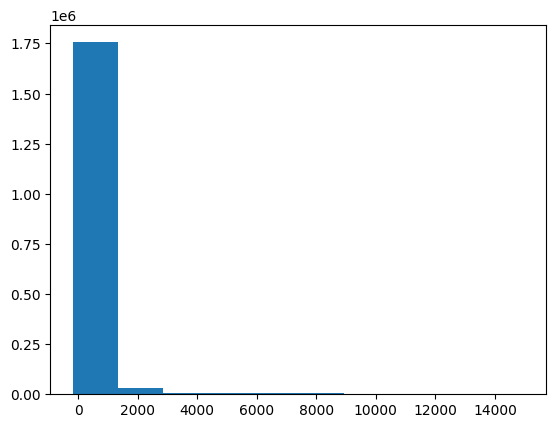

In [197]:
plt.hist(pred)

(array([1.92741e+05, 4.43200e+03, 1.22100e+03, 1.24200e+03, 9.06000e+02,
        7.62000e+02, 3.31000e+02, 1.11000e+02, 2.20000e+01, 1.50000e+01]),
 array([    0.    ,  1439.9395,  2879.879 ,  4319.8185,  5759.758 ,
         7199.6975,  8639.637 , 10079.5765, 11519.516 , 12959.4555,
        14399.395 ]),
 <BarContainer object of 10 artists>)

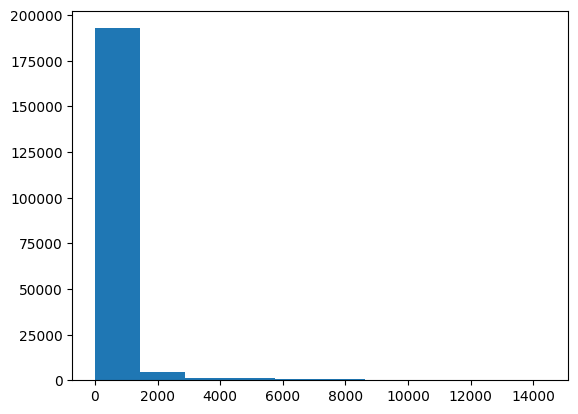

In [198]:
plt.hist(test["target"])

(array([1.763832e+06, 2.426600e+04, 8.411000e+03, 6.302000e+03,
        6.068000e+03, 3.531000e+03, 1.588000e+03, 1.066000e+03,
        7.090000e+02, 2.680000e+02]),
 array([    0.    ,  1548.0274,  3096.0548,  4644.0822,  6192.1096,
         7740.137 ,  9288.1644, 10836.1918, 12384.2192, 13932.2466,
        15480.274 ]),
 <BarContainer object of 10 artists>)

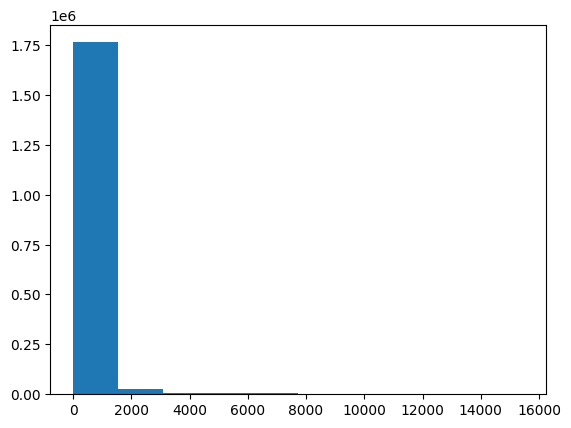

In [199]:
plt.hist(train["target"])